<a href="https://colab.research.google.com/github/DavisRayM/msft-stock-prediction/blob/main/msft-prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 4

Author: Davis Muro

For CPSC 5610

Microsoft Stock Prediction

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import activations
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, GRU, Input, BatchNormalization, Layer
from tensorflow.keras.callbacks import EarlyStopping
from typing import Tuple, List

In [2]:
np.random.seed(25)
tf.random.set_seed(25)

## Preprocessing

In [3]:
df = pd.read_csv('data/MSFT.csv', parse_dates=['Date'], index_col='Date')

# Sort dataframe by `Date` (Ascending)
df.sort_index(inplace=True)

# Drop Adj Close
df.drop(columns=['Adj Close'], inplace=True)

df.head(5)

,Open,High,Low,Close,Volume
Date,,,,,
2016-11-07,59.779999,60.520000,59.779999,60.419998,31664800
2016-11-08,60.549999,60.779999,60.150002,60.470001,22935400
2016-11-09,60.000000,60.590000,59.200001,60.169998,49632500
2016-11-10,60.480000,60.490002,57.630001,58.700001,57822400
2016-11-11,58.230000,59.119999,58.009998,59.020000,38767800


In [4]:
scalers = {col: MinMaxScaler() for col in ['Open', 'High', 'Low', 'Close', 'Volume']}
df_scaled = df.copy()
for col in scalers:
    df_scaled[col] = scalers[col].fit_transform(df[[col]])

df = df_scaled
df.head(5)

,Open,High,Low,Close,Volume
Date,,,,,
2016-11-07,0.005530,0.005148,0.009021,0.008264,0.233481
2016-11-08,0.008277,0.006078,0.010356,0.008444,0.149396
2016-11-09,0.006315,0.005398,0.006928,0.007366,0.406553
2016-11-10,0.008028,0.005041,0.001263,0.002084,0.485441
2016-11-11,0.000000,0.000143,0.002634,0.003234,0.301900


In [5]:
df.shape

(1259, 5)

## Windowing

In [6]:
train_size = df.shape[0] * 90 // 100
test_size = df.shape[0] - train_size
train_size, test_size

(1133, 126)

In [7]:
def window(series, n_steps, batch_size):
    if len(series.shape) == 1:
      series = series.reshape(-1, 1)

    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(n_steps + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda window: window.batch(n_steps + 1))
    ds = ds.map(lambda window: (window[:-1], window[-1]))
    ds = ds.batch(batch_size).prefetch(1)
    return ds

In [8]:
n_steps = 30
batch_size = 32
train = df['Close'].values[:train_size]
train = window(train, n_steps, batch_size)

for X_batch, y_batch in train.take(3):
    print(train, X_batch.shape, y_batch.shape)
    print(X_batch)
    print(y_batch)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1), dtype=tf.float64, name=None))> (32, 30, 1) (32, 1)
tf.Tensor(
[[[0.00826387]
  [0.00844353]
  [0.00736562]
  [0.00208394]
  [0.00323369]
  [0.        ]
  [0.00269474]
  [0.00549728]
  [0.00905433]
  [0.00801236]
  [0.00984479]
  [0.01077896]
  [0.00819202]
  [0.0086591 ]
  [0.00894654]
  [0.01067117]
  [0.00768899]
  [0.00388043]
  [0.00406008]
  [0.00754528]
  [0.00657517]
  [0.01167721]
  [0.01038373]
  [0.01383301]
  [0.01455159]
  [0.01746192]
  [0.01638402]
  [0.01602473]
  [0.01501868]
  [0.01976143]]

 [[0.00844353]
  [0.00736562]
  [0.00208394]
  [0.00323369]
  [0.        ]
  [0.00269474]
  [0.00549728]
  [0.00905433]
  [0.00801236]
  [0.00984479]
  [0.01077896]
  [0.00819202]
  [0.0086591 ]
  [0.00894654]
  [0.01067117]
  [0.00768899]
  [0.00388043]
  [0.00406008]
  [0.00754528]
  [0.00657517]
  [0.01167721]
  [0.01038373]
  [0.01383301]
  [0.01455159]
  

In [9]:
test = df['Close'].values[train_size:]
test = window(test, n_steps, batch_size)

for X_batch, y_batch in test.take(3):
    print(test, X_batch.shape, y_batch.shape)
    print(X_batch)
    print(y_batch)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1), dtype=tf.float64, name=None))> (32, 30, 1) (32, 1)
tf.Tensor(
[[[0.67587667]
  [0.64989939]
  [0.66437912]
  [0.6827752 ]
  [0.67210402]
  [0.66455878]
  [0.66470248]
  [0.67677492]
  [0.67206811]
  [0.69222477]
  [0.69560218]
  [0.69477581]
  [0.68694308]
  [0.68827246]
  [0.68008046]
  [0.67972119]
  [0.67400836]
  [0.69226068]
  [0.70311152]
  [0.69865624]
  [0.70232105]
  [0.71543543]
  [0.71777096]
  [0.72495693]
  [0.71945956]
  [0.7159385 ]
  [0.72858577]
  [0.72330408]
  [0.73480168]
  [0.7451495 ]]

 [[0.64989939]
  [0.66437912]
  [0.6827752 ]
  [0.67210402]
  [0.66455878]
  [0.66470248]
  [0.67677492]
  [0.67206811]
  [0.69222477]
  [0.69560218]
  [0.69477581]
  [0.68694308]
  [0.68827246]
  [0.68008046]
  [0.67972119]
  [0.67400836]
  [0.69226068]
  [0.70311152]
  [0.69865624]
  [0.70232105]
  [0.71543543]
  [0.71777096]
  [0.72495693]
  [0.71945956]
  

## Modelling

In [10]:
class BatchNormSimpleRNN(Layer):
    def __init__(self, units, return_sequences=False, dropout=0.2, recurrent_dropout=0.2, activation='tanh', **kwargs):
        super().__init__(**kwargs)
        self.simple_rnn = SimpleRNN(
            units,
            activation=None,
            return_sequences=return_sequences,
            dropout=dropout,
            recurrent_dropout=recurrent_dropout,
            **kwargs
        )
        self.batch_norm = BatchNormalization()
        self.activation_fn = activations.get(activation)

    def call(self, inputs, training=None):
        x = self.simple_rnn(inputs, training=training)
        x = self.batch_norm(x, training=training)
        return self.activation_fn(x)

In [11]:
def create_model(kind: str = "simple", input_shape: Tuple[int, int, int] = (n_steps, 1), hidden_units: List = [128, 64]):
  model = tf.keras.models.Sequential()
  model.add(Input(shape=input_shape))

  if kind == "simple":
    model.add(BatchNormSimpleRNN(hidden_units[0], return_sequences=(len(hidden_units) > 1), dropout=0.2, recurrent_dropout=0.2))

    for units in hidden_units[1:-1]:
      model.add(BatchNormSimpleRNN(units, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))

    if len(hidden_units) > 1:
      model.add(BatchNormSimpleRNN(hidden_units[-1], return_sequences=False, dropout=0.2, recurrent_dropout=0.2))
  elif kind == "lstm":
    model.add(LSTM(hidden_units[0], return_sequences=(len(hidden_units) > 1), dropout=0.2, recurrent_dropout=0.2))

    for units in hidden_units[1:-1]:
      model.add(LSTM(units, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))

    if len(hidden_units) > 1:
      model.add(LSTM(hidden_units[-1], return_sequences=False, dropout=0.2, recurrent_dropout=0.2))
  elif kind == "gru":
    model.add(GRU(hidden_units[0], return_sequences=(len(hidden_units) > 1), dropout=0.2, recurrent_dropout=0.2))

    for units in hidden_units[1:-1]:
      model.add(GRU(units, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))

    if len(hidden_units) > 1:
      model.add(GRU(hidden_units[-1], return_sequences=False, dropout=0.2, recurrent_dropout=0.2))
  else:
    assert False, "Unsupported kind: " + kind

  model.add(Dense(input_shape[1]))
  model.compile(loss="mse", optimizer="adam", metrics=["mae"])
  return model

In [12]:
early_stopping = EarlyStopping(
    monitor='val_mae',
    patience=3,
    restore_best_weights=True
)

epochs = 20

### Simple RNN

Uses SimpleRNN + Batch normalization layers with 1 hidden layer.

In [13]:
simple = create_model(kind="simple", hidden_units=[128, 64])
simple.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_norm_simple_rnn           │ (None, 30, 128)        │        17,152 │
│ (BatchNormSimpleRNN)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_norm_simple_rnn_1         │ (None, 64)             │        12,608 │
│ (BatchNormSimpleRNN)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,825 (116.50 KB)

 Trainable params: 29,441 (115.00 KB)

 Non-trainable params: 384 (1.50 KB)

In [14]:
simple.fit(train, epochs=epochs, validation_data=test, callbacks=[early_stopping])

Epoch 1/20
     35/Unknown 9s 33ms/step - loss: 0.3010 - mae: 0.4041

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


35/35 ━━━━━━━━━━━━━━━━━━━━ 11s 69ms/step - loss: 0.2986 - mae: 0.4025 - val_loss: 0.3054 - val_mae: 0.5500
Epoch 2/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - loss: 0.1009 - mae: 0.2503 - val_loss: 0.2566 - val_mae: 0.5036
Epoch 3/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.1069 - mae: 0.2698 - val_loss: 0.2523 - val_mae: 0.4992
Epoch 4/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0978 - mae: 0.2652 - val_loss: 0.2473 - val_mae: 0.4942
Epoch 5/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0960 - mae: 0.2672 - val_loss: 0.2521 - val_mae: 0.4990
Epoch 6/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0820 - mae: 0.2506 - val_loss: 0.2462 - val_mae: 0.4931
Epoch 7/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0813 - mae: 0.2499 - val_loss: 0.2610 - val_mae: 0.5079
Epoch 8/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0759 - mae: 0.2442 - val_loss: 0.2278 - val_mae: 0.4741
Epoch 9/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0832 - mae: 0

In [15]:
result = pd.DataFrame(simple.history.history)
result.head()

,loss,mae,val_loss,val_mae
0,0.215264,0.344689,0.305433,0.549955
1,0.094414,0.236797,0.256632,0.503569
2,0.083689,0.232841,0.252310,0.499249
3,0.085520,0.237055,0.247262,0.494165
4,0.077386,0.233755,0.252050,0.498988


<Axes: title={'center': 'Mean Absolute Error vs Epoch'}>

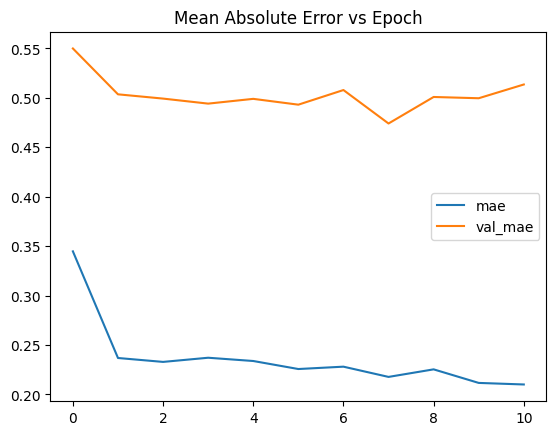

In [16]:
result[['mae', 'val_mae']].plot(title="Mean Absolute Error vs Epoch")

<Axes: title={'center': 'Loss vs Epoch'}>

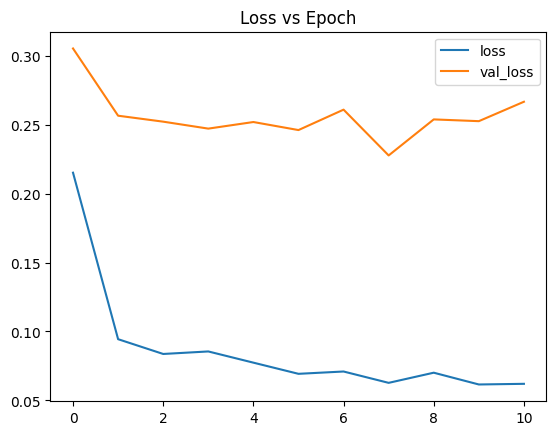

In [17]:
result[['loss','val_loss']].plot(title="Loss vs Epoch")

### GRU Model

Uses a GRU layer with one hidden layer.

In [18]:
gru = create_model(kind="gru", hidden_units=[128, 64])
gru.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 30, 128)        │        50,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 64)             │        37,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 87,617 (342.25 KB)

 Trainable params: 87,617 (342.25 KB)

 Non-trainable params: 0 (0.00 B)

In [19]:
gru.fit(train, epochs=epochs, validation_data=test, callbacks=[early_stopping])

Epoch 1/20
     35/Unknown 11s 79ms/step - loss: 0.0014 - mae: 0.0247

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


35/35 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - loss: 0.0015 - mae: 0.0252 - val_loss: 0.0280 - val_mae: 0.1587
Epoch 2/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 120ms/step - loss: 0.1195 - mae: 0.2779 - val_loss: 0.0346 - val_mae: 0.1835
Epoch 3/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 144ms/step - loss: 0.0210 - mae: 0.1263 - val_loss: 0.0022 - val_mae: 0.0390
Epoch 4/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 87ms/step - loss: 0.0461 - mae: 0.1878 - val_loss: 0.0154 - val_mae: 0.1218
Epoch 5/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step - loss: 0.0222 - mae: 0.1319 - val_loss: 0.0256 - val_mae: 0.1583
Epoch 6/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - loss: 0.0137 - mae: 0.1028 - val_loss: 0.0242 - val_mae: 0.1538


In [20]:
result = pd.DataFrame(gru.history.history)
result.head()

,loss,mae,val_loss,val_mae
0,0.004058,0.044985,0.028041,0.158715
1,0.059219,0.194195,0.034603,0.183452
2,0.024404,0.129068,0.002219,0.038997
3,0.034795,0.147072,0.015419,0.121760
4,0.025321,0.115252,0.025601,0.158284


<Axes: title={'center': 'Mean Absolute Error vs Epoch'}>

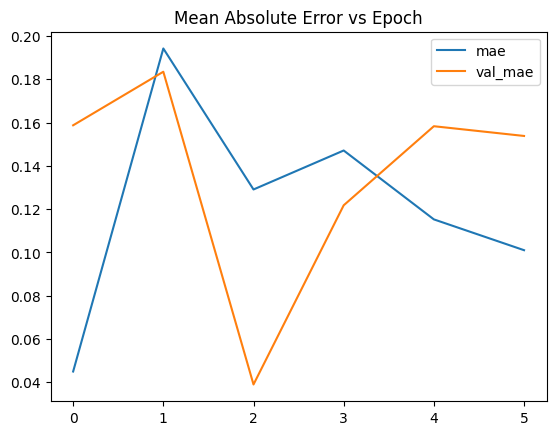

In [21]:
result[['mae', 'val_mae']].plot(title="Mean Absolute Error vs Epoch")

<Axes: title={'center': 'Loss vs Epoch'}>

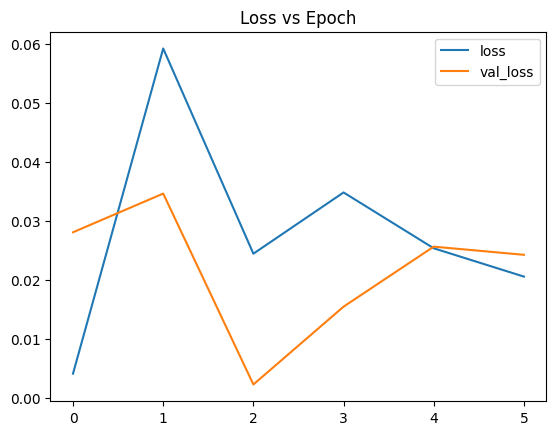

In [22]:
result[['loss','val_loss']].plot(title="Loss vs Epoch")

### LSTM

Uses LSTM layers with 1 hidden layer.

In [23]:
lstm = create_model(kind="lstm", hidden_units=[128, 64])
lstm.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 30, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 116,033 (453.25 KB)

 Trainable params: 116,033 (453.25 KB)

 Non-trainable params: 0 (0.00 B)

In [24]:
lstm.fit(train, epochs=epochs, validation_data=test, callbacks=[early_stopping])

Epoch 1/20
     35/Unknown 13s 123ms/step - loss: 0.0012 - mae: 0.0216

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


35/35 ━━━━━━━━━━━━━━━━━━━━ 15s 169ms/step - loss: 0.0013 - mae: 0.0222 - val_loss: 0.0028 - val_mae: 0.0432
Epoch 2/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 146ms/step - loss: 0.1313 - mae: 0.2802 - val_loss: 0.0114 - val_mae: 0.1020
Epoch 3/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 10s 297ms/step - loss: 0.0174 - mae: 0.1138 - val_loss: 0.0061 - val_mae: 0.0709
Epoch 4/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 14s 95ms/step - loss: 0.0351 - mae: 0.1678 - val_loss: 0.0239 - val_mae: 0.1516


In [25]:
result = pd.DataFrame(lstm.history.history)
result.head()

,loss,mae,val_loss,val_mae
0,0.004313,0.044223,0.002819,0.043172
1,0.066565,0.202003,0.011376,0.101995
2,0.023497,0.120038,0.006071,0.070946
3,0.032185,0.143069,0.023856,0.151605


<Axes: title={'center': 'Mean Absolute Error vs Epoch'}>

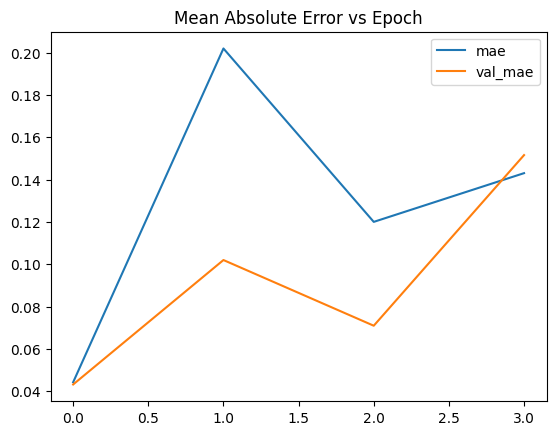

In [26]:
result[['mae', 'val_mae']].plot(title="Mean Absolute Error vs Epoch")

<Axes: title={'center': 'Loss vs Epoch'}>

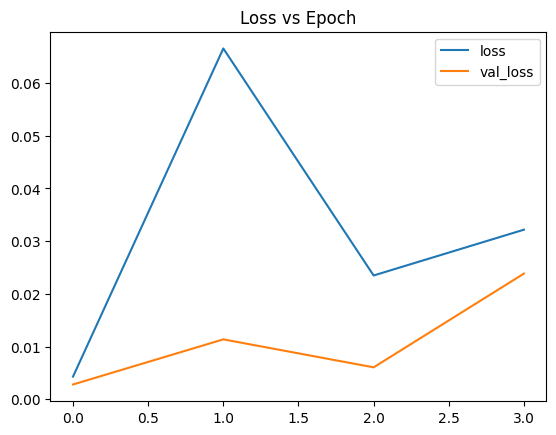

In [27]:
result[['loss','val_loss']].plot(title="Loss vs Epoch")

## Evaluation

In [28]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


def predict(model, input_seq, steps=10):
    predictions = []
    input_seq = input_seq.copy()

    for _ in range(steps):
        pred = model.predict(input_seq, verbose=0)
        predictions.append(pred[0])

        input_seq = np.concatenate([input_seq[:, 1:, :], pred[:, np.newaxis, :]], axis=1)

    return np.array(predictions)


def evaluate_predictions(true_values, predictions, feature_names, dates):
  for i, feature in enumerate(feature_names):
    mse = mean_squared_error(true_values[:, i], predictions[:, i])
    mae = mean_absolute_error(true_values[:, i], predictions[:, i])
    r2 = r2_score(true_values[:, i], predictions[:, i])
    print(f"{feature}: MSE={mse:.4f}, MAE={mae:.4f}, R²={r2:.4f}")


def plot_predictions(true_values, predictions, feature_names, all_dates):
    combined = np.concatenate([true_values, predictions], axis=0)
    split = len(true_values)

    plt.figure(figsize=(20, 10))

    for i, feature in enumerate(feature_names):
        plt.subplot((len(feature_names) + 1) // 2, 2, i+1)

        plt.plot(all_dates, combined[:, i], color='blue', label='True + Predicted')

        plt.axvline(all_dates[split], color='red', linestyle='--')
        plt.title(f"{feature}: True then Predicted")
        plt.xlabel("Date")
        plt.ylabel(feature)

        if i == 0:
            plt.legend(['True + Predicted', 'Prediction Start'])

    plt.tight_layout()
    plt.show()

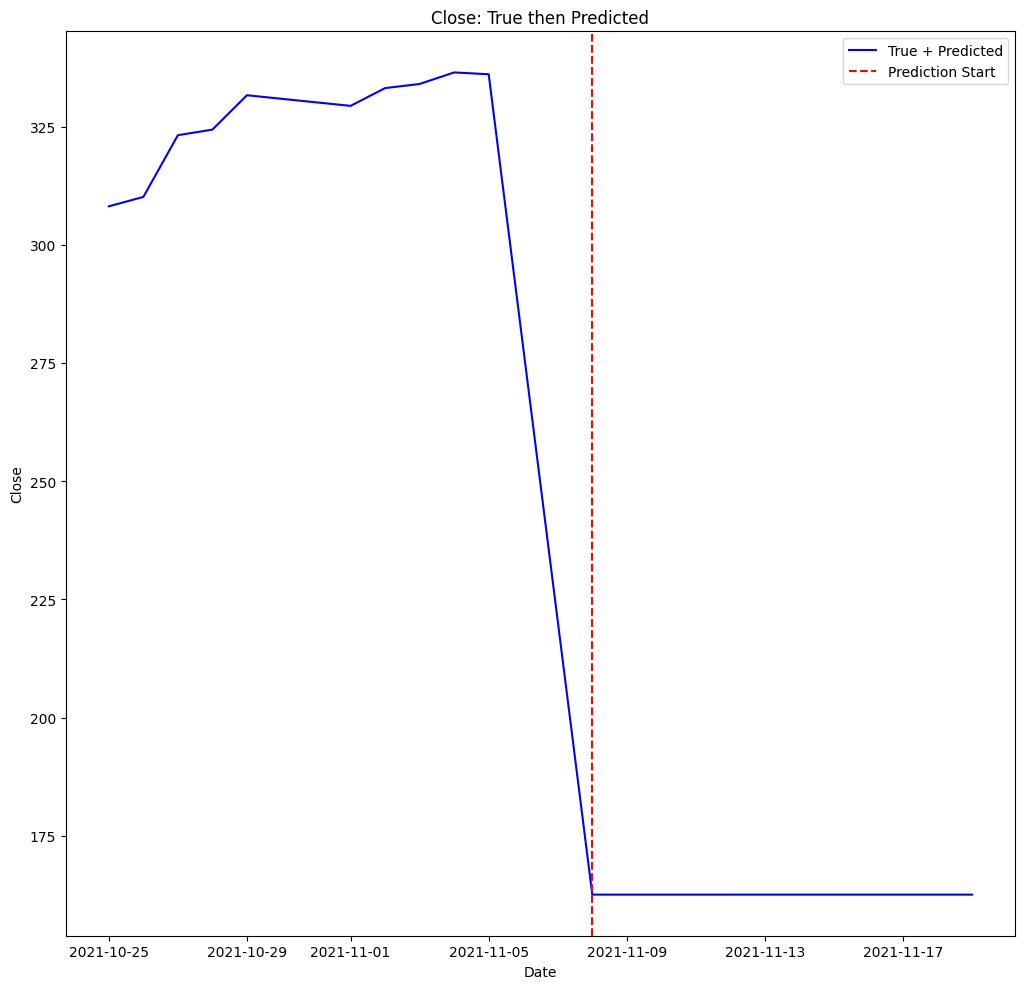

In [29]:
from pandas.tseries.offsets import BDay

predict_start = pd.Timestamp('2021-10-25')
true_end = pd.Timestamp('2021-11-05')
pred_end = pd.Timestamp('2021-11-19')

input_start = predict_start - BDay(n_steps)
input_window = df[['Close']].loc[input_start : predict_start - BDay(1)]
input_seq = input_window.values[np.newaxis, :, :]

dates_true = df.loc[predict_start:true_end].index
true_values = np.column_stack([
    scalers["Open"].inverse_transform(df.loc[dates_true, ['Open']].values),
    scalers["High"].inverse_transform(df.loc[dates_true, ['High']].values),
    scalers["Low"].inverse_transform(df.loc[dates_true, ['Low']].values),
    scalers["Close"].inverse_transform(df.loc[dates_true, ['Close']].values),
    scalers["Volume"].inverse_transform(df.loc[dates_true, ['Volume']].values)
])
dates_pred = pd.bdate_range(start=true_end + BDay(1), end=pred_end)
steps = len(dates_pred)
all_dates = dates_true.append(dates_pred)

pred_close = predict(simple, input_seq, steps)
pred_close = scalers['Close'].inverse_transform(pred_close)

plot_predictions(
    true_values=true_values[:, 3:4],
    predictions=pred_close,
    feature_names=['Close'],
    all_dates=all_dates
)

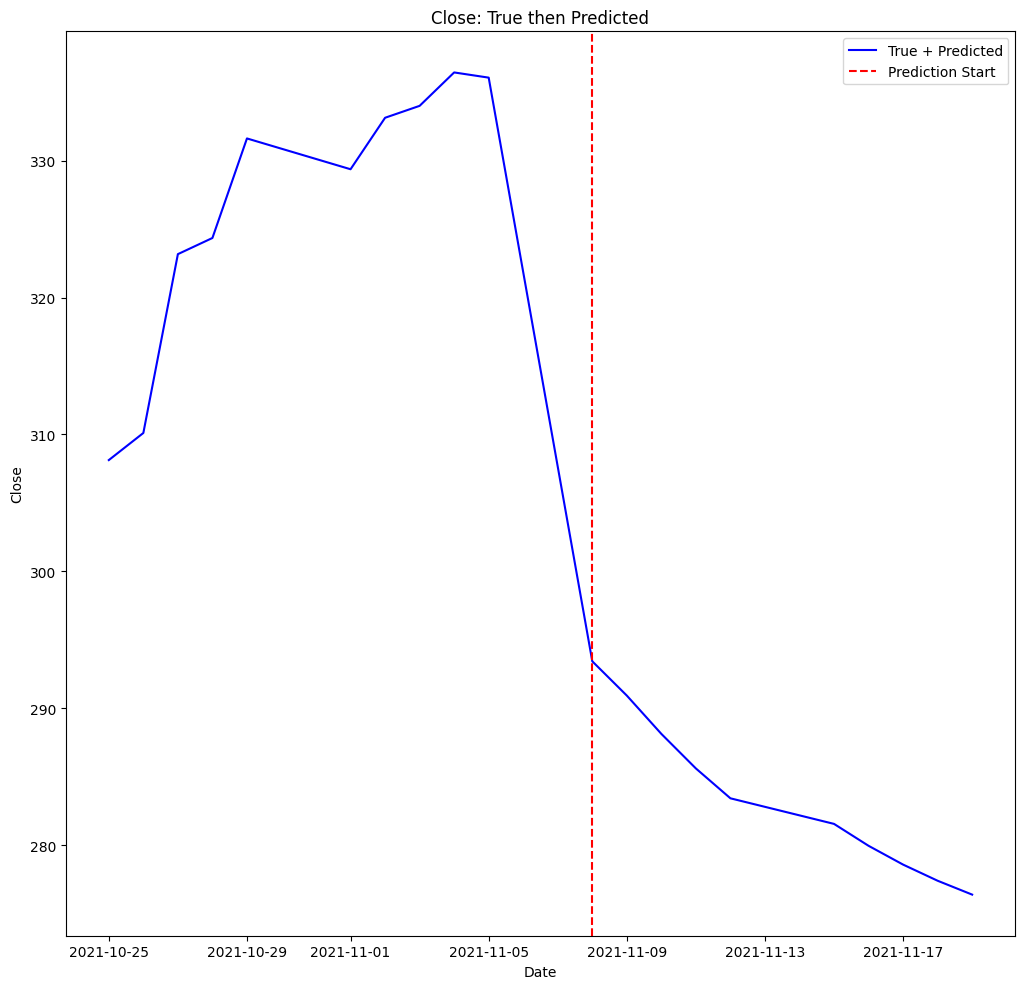

In [30]:
pred_close = predict(gru, input_seq, steps)
pred_close = scalers['Close'].inverse_transform(pred_close)

plot_predictions(
    true_values=true_values[:, 3:4],
    predictions=pred_close,
    feature_names=['Close'],
    all_dates=all_dates
)

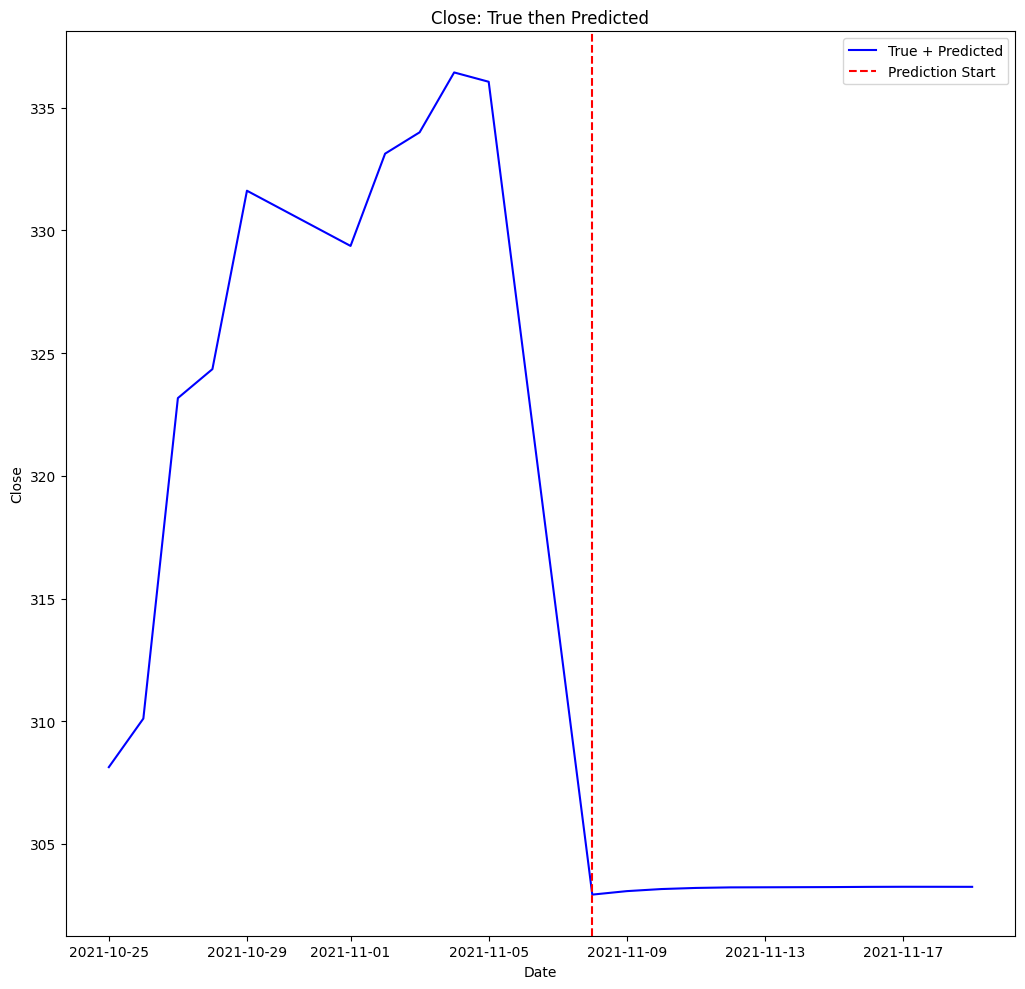

In [31]:
pred_close = predict(lstm, input_seq, steps)
pred_close = scalers['Close'].inverse_transform(pred_close)

plot_predictions(
    true_values=true_values[:, 3:4],
    predictions=pred_close,
    feature_names=['Close'],
    all_dates=all_dates
)

In [32]:
!jupyter nbconvert msft_prediction.ipynb --to html

[NbConvertApp] Converting notebook msft_prediction.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 7 image(s).
[NbConvertApp] Writing 821572 bytes to msft_prediction.html
